In [21]:
from IPython.display import display, HTML

In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import warnings
warnings.filterwarnings("ignore")

In [24]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import transformers
import pandas as pd
import numpy as np
from transformers import BertModel, BertTokenizer
from Scripts.utils.bert_utils import load_tokenizer
from nltk.corpus import stopwords 
from Scripts.utils.preprocess_utils import preprocess_texts
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import random
import itertools
from Scripts.utils.bert_embeddings import load_bert_embeddings
from Scripts.utils.clustering_utils import run_clustering, get_cluster_sizes, score_cluster, get_cluster_pairs, get_pairwise_dist, cluster2doc, filter_clusters, get_top_100_clusterpairs
from Scripts.utils.general_utils import timer
import Scripts.utils.config as CONFIG
from attm_utils import load_pickle
from attm_dataloaders import CPDatasetMT, CPDatasetST
from attm_data_utils import get_train_test_ssda
from attm_metrics import calculate_scores, calculate_scores_single, get_accuracy_from_logits,print_res
from attm_model_utils import evaluate_mt, evaluate_st
from attm_single_task import AttentionST
from attm_multi_task import AttentionMT
import  gc
import time
import pickle
import dill

In [25]:
from attm_utils import batch_text_gen, batch_gen_pred, tokenize_4bert_batch

In [26]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['axes.grid'] = True

In [27]:
np.random.seed(CONFIG.RANDOM_SEED)

In [28]:
torch.manual_seed(24)

In [29]:
torch.multiprocessing.set_sharing_strategy('file_system')

In [30]:
# Datagen from clean_df

In [31]:
def run_ssda_cp_mt(df,cp,doc_2_cluster_map,
                   learning_rates=[0.0001,0.001,0.01,0.1],
                   epochs=3,
                   word_pred_loss_weights=[0.3,0.8],
                   batch_size=8,
                   neg_sample_size=3,
                   single_task=False,
                   cuda_device=torch.device('cuda:1')):
    """
    Uses a self supervised domain adaptation setting to train the model
    
    * train = 90% c1 data + 10% c2 data
    * test = 50% c1 data + 50% c2 data
    
    * From cluster 1 choose 70% of the data for train, 30% for test
    * From cluster 2 choose 10% of 70% from c1 for train, 
    
    * Loss check
    * Metrics = F1, recall, precision, accuracy, roc
    """
    train, test = get_train_test_ssda(df,cp,doc_2_cluster_map,neg_sample_size=neg_sample_size,single_task=single_task)
    metrics_train = {}
    metrics_test = {}
    losses_train = {}
    # train ssda func
    for lr in learning_rates:
        for word_loss_w in word_pred_loss_weights:
            
            # FREE MEMORY
            model = None
            gc.collect()
            torch.cuda.empty_cache()

            model, epoch_losses, scores_train, scores_test = run_ssda_MT(train,test,lr,word_loss_w,epochs=epochs,batch_size=batch_size,cuda_device=cuda_device,num_workers=4)
            metrics_train[(lr,word_loss_w)] = scores_train
            metrics_test[(lr,word_loss_w)] = scores_test
            losses_train[(lr,word_loss_w)] = epoch_losses
            
    return metrics_train,metrics_test, losses_train

def run_ssda_cp_st(df,cp,doc_2_cluster_map,
                   learning_rates=[0.0001,0.001,0.01,0.1],
                   epochs=3,
                   word_pred_loss_weights=[0.3,0.8],
                   batch_size=8,
                   neg_sample_size=3,
                   single_task=True,
                   with_attention=True,
                   cuda_device=torch.device('cuda:1')):
    """
    Uses a self supervised domain adaptation setting to train the model
    
    * train = 90% c1 data + 10% c2 data
    * test = 50% c1 data + 50% c2 data
    
    * From cluster 1 choose 70% of the data for train, 30% for test
    * From cluster 2 choose 10% of 70% from c1 for train, 
    
    * Loss check
    * Metrics = F1, recall, precision, accuracy, roc
    """
    train, test = get_train_test_ssda(df,cp,doc_2_cluster_map,neg_sample_size=neg_sample_size,single_task=single_task)
    metrics_train = {}
    metrics_test = {}
    losses_train = {}
    # train ssda func
    for lr in learning_rates:
            
        # FREE MEMORY
        model = None
        gc.collect()
        torch.cuda.empty_cache()

        model, epoch_losses, scores_train, scores_test = run_ssda_ST(train,test,lr,epochs=epochs,batch_size=batch_size,cuda_device=cuda_device,num_workers=4,with_attention=with_attention)

        metrics_train[(lr)] = scores_train
        metrics_test[(lr)] = scores_test
        losses_train[(lr)] = epoch_losses
            
    return metrics_train,metrics_test, losses_train

In [32]:
@timer
def run_ssda_MT(train,test,lr,word_loss_w,epochs=2,batch_size=8,cuda_device=torch.device('cuda:1'),num_workers=1):
    """
    """
    model = AttentionMT(embedding_size=768,verbose=False,which_forward=2)
    model.to(cuda_device)
    loss_func = nn.BCELoss()
    opt = torch.optim.Adam(model.parameters(),lr=lr)
    
    epoch_losses = {}
    total_losses = []
    word_losses = []
    rs_losses = []
    
    train_dataset = CPDatasetMT(train)
    test_dataset = CPDatasetMT(test)
    train_dataloader = DataLoader(train_dataset,batch_size=batch_size,num_workers=num_workers, shuffle=True)
    test_dataloader = DataLoader(test_dataset,batch_size=batch_size,num_workers=num_workers,shuffle=True)
    
    for epoch in range(epochs):
        
        for batch_num, (x1,x2,y1,y2,wc) in enumerate(train_dataloader):

            x1,x2,y1,y2 = x1.to(cuda_device),x2.to(cuda_device),y1.to(cuda_device),y2.to(cuda_device)
            
            opt.zero_grad() # reset all the gradient information
    
            y_pred, context_pred, attention_vector = model(x1, x2)
            
            rec_loss = loss_func(y_pred,y1)
            word_loss = loss_func(context_pred,y2)
            
            total_loss = rec_loss + (word_loss_w * word_loss)
            
            total_loss.backward()
            
            opt.step()
            
            rs_losses.append(rec_loss.item())
            word_losses.append(word_loss.item())
            total_losses.append(total_loss.item())
            
            if batch_num % 100 == 0 and batch_num >=100:
                print("Epoch : %s | Batch : %s | Total Loss : %s | Rec Loss : %s | Word Loss : %s" % (str(epoch),str(batch_num),str(total_loss.item()),str(rec_loss.item()),str(word_loss.item())))
                print("True Rec Labels : %s" %str(y1))
                print("True Word Labels : %s" %str(y2))
                print("Batch Class Predictions : %s"%str(y_pred))
                print("Batch Word Label Predictions : %s"%str(context_pred))
                print("Batch Accuracy class : %s"%str(get_accuracy_from_logits(y_pred,y1)))
                print("Batch Accuracy word : %s"%str(get_accuracy_from_logits(context_pred,y2)))
            
            
    epoch_losses["rs_loss"] = rs_losses
    epoch_losses["word_loss"] = word_losses
    epoch_losses["total_loss"] = total_losses

    scores_train = evaluate_mt(model,train_dataloader)
    scores_test = evaluate_mt(model,test_dataloader)
    
    x1 = None
    x2 = None
    y1 = None
    y2 = None
    rec_loss = None
    total_loss = None
    word_loss = None
    opt = None
    

    del x1
    del x2
    del y1
    del y2

    gc.collect()
    torch.cuda.empty_cache()
    
    return model, epoch_losses, scores_train, scores_test

@timer
def run_ssda_ST(train,test,lr,epochs=2,batch_size=8,cuda_device=torch.device('cuda:1'),num_workers=1,with_attention=True):
    """
    """
    model = AttentionST(embedding_size=768,verbose=False,which_forward=2,with_attention=with_attention)
    model.to(cuda_device)
    loss_func = nn.BCELoss()
    opt = torch.optim.Adam(model.parameters(),lr=lr)
    
    epoch_losses = {}
    total_losses = []
    word_losses = []
    rs_losses = []
    
    train_dataset = CPDatasetST(train)
    test_dataset = CPDatasetST(test)
    train_dataloader = DataLoader(train_dataset,batch_size=batch_size,num_workers=num_workers,shuffle=True)
    test_dataloader = DataLoader(test_dataset,batch_size=20,num_workers=num_workers,shuffle=True)
    
    for epoch in range(epochs):
        
        for batch_num, (x1,y1,wc) in enumerate(train_dataloader):

            x1,y1 = x1.to(cuda_device),y1.to(cuda_device)
            
            opt.zero_grad() # reset all the gradient information
    
            y_pred, attention_vector = model(x1)
            
            total_loss = loss_func(y_pred,y1.squeeze()) 
            
            total_loss.backward()
            
            opt.step()
            
            total_losses.append(total_loss.item())
            
            if batch_num % 100 == 0 and batch_num >=100:
                print("Epoch : %s | Batch : %s | Total Loss : %s " % (str(epoch),str(batch_num),str(total_loss.item())))
                print("True Rec Labels : %s" %str(y1))
                print("Batch Class Predictions : %s"%str(y_pred))
                print("Batch Accuracy class : %s"%str(get_accuracy_from_logits(y_pred,y1)))
            
    epoch_losses["total_loss"] = total_losses
        
    scores_train = evaluate_st(model,train_dataloader)
    scores_test = evaluate_st(model,test_dataloader)
    
    x1 = None
    y1 = None
    total_loss = None
    opt = None
    

    del x1
    del y1

    gc.collect()
    torch.cuda.empty_cache()
    
    return model, epoch_losses, scores_train, scores_test
    

In [33]:
@timer
def select_cps(cps,cluster_2_doc_map,df,keywords=["democrats", "media","socialist","donald", "republicans", "progressive"]):
    """
    calculate normalized dfs for each cluster pair keywords (sum them for indiv clusters) then rank and then find avg rank
    
    cluster, keyword = doc_freq
    """
    # Get Document frequency for keywords
    clusters = list(set(np.array([[cp[0],cp[1]] for cp in cps]).flatten().tolist()))
    df["processed_all"] = df["processed_title"] + " "+ df['processed_text']
    print("Num clusters : %s" %str(len(clusters)))
    print(clusters)
    keyword_clus_doc_freq = defaultdict(lambda :defaultdict(int))
    for cluster in clusters:
        c_docs = cluster_2_doc_map[cluster]
        for c_doc in c_docs:
            for keyword in keywords:
                if keyword in df["processed_all"].iloc[c_doc]:
                    keyword_clus_doc_freq[cluster][keyword]+=1
        
    # Now lets normalize the scores
    for cluster in clusters:
        for keyword in keywords:
            c_docs = cluster_2_doc_map[cluster]
            if keyword_clus_doc_freq[cluster][keyword] > 0:
                keyword_clus_doc_freq[cluster][keyword] /= len(c_docs)
    
    print(keyword_clus_doc_freq)
    
    # Now lets rank cps
    keyword_clusp_ranks = []
    for cp in cps:
        c1_normdf_total = 0
        c2_normdf_total = 0
        for keyword in keywords:
            c1_normdf_total += keyword_clus_doc_freq[cp[0]][keyword]
            c2_normdf_total += keyword_clus_doc_freq[cp[1]][keyword]
        
        total_cp_norm_df = c1_normdf_total + c2_normdf_total
        keyword_clusp_ranks.append((cp,total_cp_norm_df))
    
    return sorted(keyword_clusp_ranks,key=lambda x: x[1],reverse=True)
        
            

In [35]:
# cps = load_pickle('top100.pickle')

In [36]:
data = load_pickle("att_pickle_objs_input/clean_df.pickle")

In [37]:
data.shape

(95120, 9)

In [38]:
data.columns

Index(['title', 'text', 'source_partisan_score', 'binary_ps', 'processed_text',
       'processed_title', 'context_word_pos', 'context_word_neg', 'drop_'],
      dtype='object')

In [40]:
doc_2_cluster_map = load_pickle('att_pickle_objs_input/d2c_map.pickle')

In [30]:
type(cps[0][0])

int

In [41]:
sorted_cps = select_cps(cps,doc_2_cluster_map,data,keywords=["democrats", "media","socialist","donald", "republicans", "progressive"])

Num clusters : 40
[0, 1, 4, 7, 9, 14, 15, 16, 20, 22, 26, 28, 30, 35, 36, 38, 39, 43, 44, 46, 52, 56, 57, 58, 59, 60, 61, 62, 63, 71, 74, 82, 85, 86, 89, 91, 93, 97, 98, 99]
defaultdict(<function select_cps.<locals>.<lambda> at 0x7f223e579ca0>, {0: defaultdict(<class 'int'>, {'democrats': 0.5737142857142857, 'republicans': 0.3417142857142857, 'media': 0.23314285714285715, 'socialist': 0.029714285714285714, 'donald': 0.312, 'progressive': 0.048}), 1: defaultdict(<class 'int'>, {'democrats': 0.26877761413843887, 'media': 0.36818851251840945, 'donald': 0.31516936671575846, 'republicans': 0.13843888070692195, 'progressive': 0.061855670103092786, 'socialist': 0.029455081001472753}), 4: defaultdict(<class 'int'>, {'donald': 0.25183823529411764, 'republicans': 0.09099264705882353, 'democrats': 0.17738970588235295, 'media': 0.32536764705882354, 'socialist': 0.012867647058823529, 'progressive': 0.03768382352941176}), 7: defaultdict(<class 'int'>, {'democrats': 0.44642857142857145, 'media': 0.24

In [42]:
data.columns

Index(['title', 'text', 'source_partisan_score', 'binary_ps', 'processed_text',
       'processed_title', 'context_word_pos', 'context_word_neg', 'drop_',
       'processed_all'],
      dtype='object')

In [43]:
sorted_cps

[((14, 44), 2.864814723197942),
 ((0, 30), 2.8013562537048013),
 ((22, 58), 2.787720648008361),
 ((22, 36), 2.7679559062975994),
 ((1, 22), 2.666853479614474),
 ((1, 86), 2.6176551748647188),
 ((44, 74), 2.616952076942841),
 ((36, 58), 2.585739845445201),
 ((14, 43), 2.57426145468885),
 ((30, 74), 2.530989815689094),
 ((71, 93), 2.502433860407608),
 ((71, 74), 2.480766831399441),
 ((15, 93), 2.4746861516683425),
 ((30, 63), 2.467166102559019),
 ((15, 74), 2.4530191226601756),
 ((60, 63), 2.411508250239005),
 ((43, 44), 2.4075123328365766),
 ((15, 71), 2.3979474015196027),
 ((57, 93), 2.3824489299903764),
 ((57, 74), 2.36078190098221),
 ((82, 93), 2.340606713441439),
 ((43, 74), 2.3263988084337495),
 ((30, 82), 2.3140909475823523),
 ((44, 52), 2.3035043453882813),
 ((26, 93), 2.291744578659469),
 ((15, 57), 2.277962471102372),
 ((26, 74), 2.270077549651302),
 ((26, 30), 2.265228812800382),
 ((43, 63), 2.2625750953036743),
 ((60, 82), 2.2584330952623386),
 ((63, 82), 2.255115971303197),


In [73]:
metrics_train,metrics_test, losses_train =  run_ssda_cp_st(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.0001,0.001,0.01],
                                                            epochs=5,
                                                            batch_size=4,
                                                            single_task=True,
                                                            with_attention=True)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)

Sample size from C1 in Train : (975, 10)
1 : 423
0 : 552

Sample size from C2 in Train : (97, 10)
1 : 50
0 : 47

Train Size : (1072, 10)
1 : 473
0 : 599

Sample Size from C1 in Test : (419, 10)
1 : 174
0 : 245

Sample Size from C2 in Test : (419, 10)
1 : 215
0 : 204

Test Size : (838, 10)
1 : 389
0 : 449


KeyboardInterrupt: 

In [48]:
metrics_train.keys()

dict_keys([0.01, 0.1])

In [49]:
losses_train.keys()

dict_keys([0.01, 0.1])

In [74]:
metrics_train,metrics_test, losses_train =  run_ssda_cp_mt(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.0001,0.001,0.01],
                                                            word_pred_loss_weights=[0.1,0.3,0.8,1.0],
                                                            epochs=5,
                                                            batch_size=4,
                                                            single_task=False)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)
Exploded Train Shape : (7666, 4)
Exploded Test Shape : (6617, 4)

Sample size from C1 in Train : (5366, 5)
1 : 2354
0 : 3012

Sample size from C2 in Train : (536, 5)
1 : 264
0 : 272

Train Size : (5902, 5)
1 : 2618
0 : 3284

Sample Size from C1 in Test : (2300, 5)
1 : 983
0 : 1317

Sample Size from C2 in Test : (2300, 5)
1 : 1071
0 : 1229

Test Size : (4600, 5)
1 : 2054
0 : 2546
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


KeyboardInterrupt: 

In [44]:
train_scores = None
with open("att_pickle_objs_results/(0, 30)_metrics_train_single.pickle","rb") as handle:
    train_scores = dill.load(handle)

In [45]:
train_scores.keys()

dict_keys([1e-05, 0.0001, 0.001, 0.01])

In [46]:
train_scores[0.01].keys()

dict_keys(['overall', 'cluster1', 'cluster2'])

In [47]:
train_scores[0.01]["overall"]

defaultdict(<function attm_metrics.<lambda>()>,
            {'class_scores': defaultdict(float,
                         {'f1': 0.7741935483870968,
                          'precision': 0.6540284360189573,
                          'recall': 0.9484536082474226,
                          'accuracy': 0.7831273276839208,
                          'roc_auc': 0.7607726597325408})})

In [48]:
train_loss = None
with open("att_pickle_objs_results/(0, 30)_loss_single.pickle","rb") as handle:
    train_loss = dill.load(handle)

In [49]:
train_loss.keys()

dict_keys([1e-05, 0.0001, 0.001, 0.01])

422.5

In [56]:


N = 5
max_val, min_val = 0.01, 0.00000001
range_size = (max_val - min_val)  # 2
np.random.rand(N) * range_size + min_val

array([3.41245396e-03, 8.08114567e-03, 3.30546702e-03, 8.55788631e-03,
       8.65761124e-05])

In [60]:
def random_search_lr(n,max_lr=0.001,min_lr=0.0000001):
    """
    """
    range_size = (max_lr - min_lr)  # 2
    lrs = (np.random.rand(n) * range_size + min_lr).tolist()
    return lrs

In [61]:
lr = random_search_lr(10)

In [62]:
lr

[0.0007231048406679875,
 0.00039861319973326647,
 0.00015914792150126708,
 0.0006502884253383948,
 0.0006411521123407676,
 0.00023396399376241435,
 0.00012714200346605468,
 0.0003312195494200387,
 0.00031714525589067124,
 0.000781623522986814]

In [62]:
def plot_epoch_loss_multi(epoch_losses):
    """
    """
    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(25,10))
    ax.plot(range(len(epoch_losses["total_loss"])),epoch_losses["total_loss"],c="green",alpha=0.4,label="Total Loss")
    ax.plot(range(len(epoch_losses["word_loss"])),epoch_losses["word_loss"],c="blue",alpha=0.3,label="Word Loss")
    ax.plot(range(len(epoch_losses["rs_loss"])),epoch_losses["rs_loss"],c="red",label="RS Loss")
    ax.set_xlabel("Batch Num")
    ax.set_ylabel("Training Loss")
    ax.set_title("Training Loss for ATMT")
    plt.legend()
    plt.show()

In [44]:
def plot_epoch_loss(epoch_losses):
    """
    """
    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(25,10))
    ax.plot(range(len(epoch_losses["total_loss"])),epoch_losses["total_loss"],c="green",label="Total Loss")
    ax.set_xlabel("Batch Num")
    ax.set_ylabel("Training Loss")
    plt.legend()
    plt.show()

In [65]:
scores_test =  None
losses_train = None
with open("att_pickle_objs_results/(14, 44)_metrics_test_single.pickle","rb") as mt:
    scores_test = dill.load(mt)
with open("att_pickle_objs_results/(14, 44)_loss_single.pickle","rb") as mt:
    losses_train = dill.load(mt)

In [66]:
print_res(scores_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,0.00100,overall,class_scores,0.449468,0.465565,0.434447,0.505967,0.501188
1,0.00100,cluster1,class_scores,0.558282,0.598684,0.522989,0.656325,0.637004
2,0.00100,cluster2,class_scores,0.366197,0.369668,0.362791,0.355609,0.355415
3,0.00010,overall,class_scores,0.200758,0.381295,0.136247,0.496420,0.472355
4,0.00010,cluster1,class_scores,0.236842,0.500000,0.155172,0.584726,0.522484
5,0.00010,cluster2,class_scores,0.173333,0.305882,0.120930,0.408115,0.415857
6,0.00001,overall,class_scores,0.043373,0.346154,0.023136,0.526253,0.492637
7,0.00001,cluster1,class_scores,0.052910,0.333333,0.028736,0.572792,0.493960
8,0.00001,cluster2,class_scores,0.035398,0.363636,0.018605,0.479714,0.492145


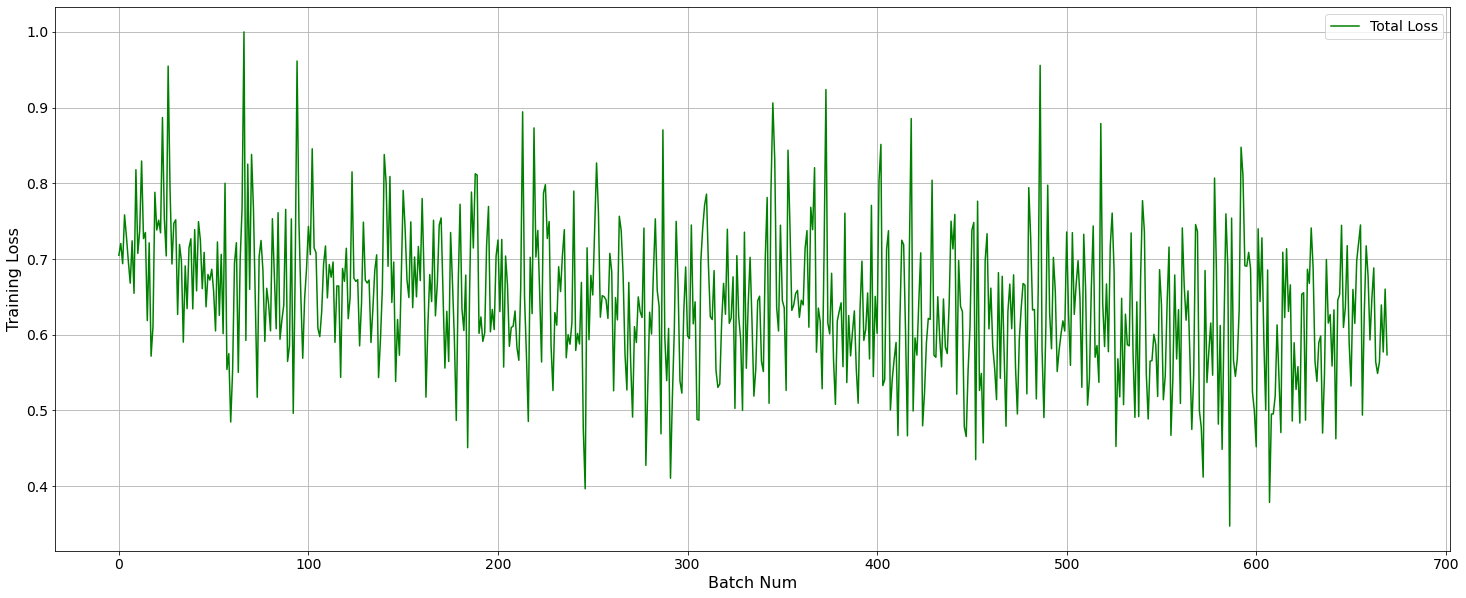

In [75]:
plot_epoch_loss(losses_train[0.001])

In [68]:
scores_test_w_att =  None
losses_train_w_att = None
with open("att_pickle_objs_results/(14, 44)_metrics_test_single_att.pickle","rb") as mt:
    scores_test_w_att = dill.load(mt)
with open("att_pickle_objs_results/(14, 44)_loss_single_att.pickle","rb") as mt:
    losses_train_w_att = dill.load(mt)

In [69]:
print_res(scores_test_w_att)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,0.00100,overall,class_scores,0.380518,0.466418,0.321337,0.514320,0.501426
1,0.00100,cluster1,class_scores,0.594406,0.758929,0.488506,0.723150,0.689151
2,0.00100,cluster2,class_scores,0.215633,0.256410,0.186047,0.305489,0.308710
3,0.00010,overall,class_scores,0.188235,0.396694,0.123393,0.505967,0.480405
4,0.00010,cluster1,class_scores,0.207207,0.479167,0.132184,0.579952,0.515072
5,0.00010,cluster2,class_scores,0.173611,0.342466,0.116279,0.431981,0.440492
6,0.00001,overall,class_scores,0.000000,0.000000,0.000000,0.535800,0.500000
7,0.00001,cluster1,class_scores,0.000000,0.000000,0.000000,0.584726,0.500000
8,0.00001,cluster2,class_scores,0.000000,0.000000,0.000000,0.486874,0.500000


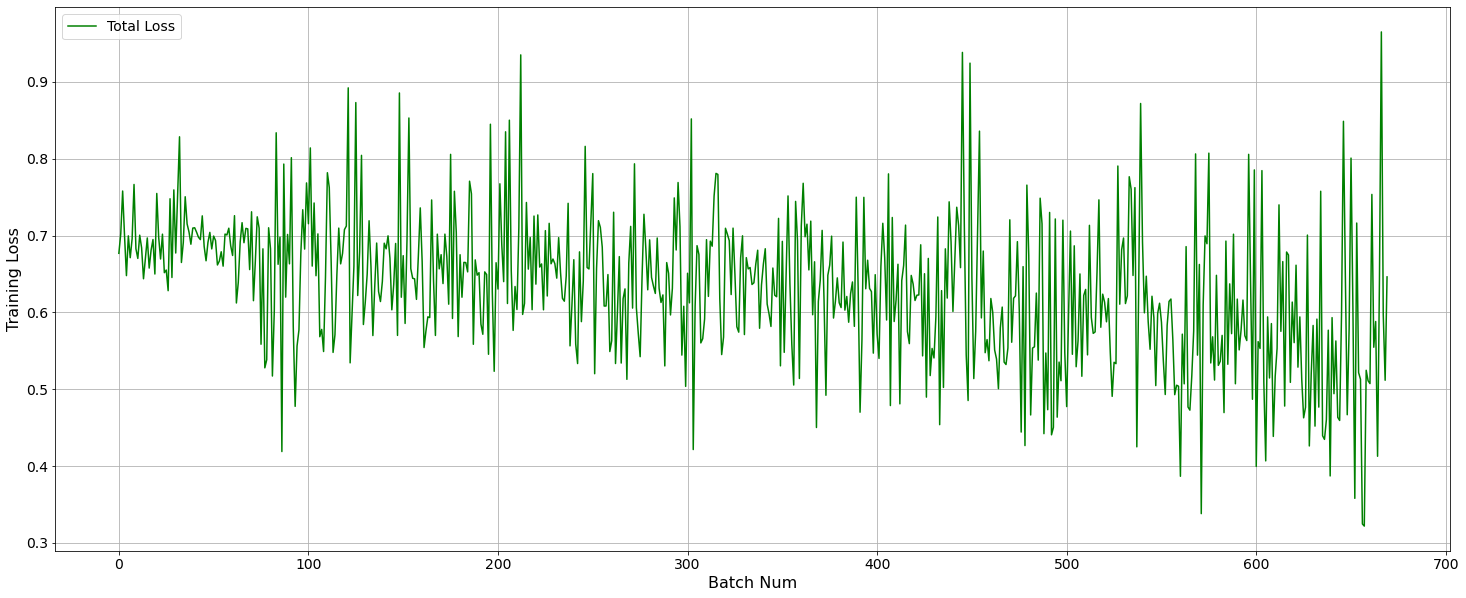

In [70]:
plot_epoch_loss(losses_train_w_att[0.001])

In [71]:
scores_test_multi_att = None
losees_train_multi_att = None
with open("att_pickle_objs_results/(14, 44)_metrics_test_multi_att.pickle","rb") as mt:
    scores_test_multi_att = dill.load(mt)
with open("att_pickle_objs_results/(14, 44)_loss_multi_att.pickle","rb") as mt:
    losees_train_multi_att = dill.load(mt)

In [72]:
print_res(scores_test_multi_att)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 0.1)",overall,class_scores,0.599106,0.453952,0.880721,0.473696,0.513023
1,"(0.001, 0.1)",overall,word_scores,0.559884,0.450832,0.738528,0.471957,0.494065
2,"(0.001, 0.1)",cluster1,class_scores,0.621300,0.466769,0.928789,0.516087,0.568419
3,"(0.001, 0.1)",cluster1,word_scores,0.556126,0.449852,0.728146,0.473913,0.495924
4,"(0.001, 0.1)",cluster2,class_scores,0.578065,0.441597,0.836601,0.431304,0.457357
5,"(0.001, 0.1)",cluster2,word_scores,0.563552,0.451780,0.748811,0.470000,0.492099
6,"(0.001, 0.4)",overall,class_scores,0.322156,0.495951,0.238559,0.551739,0.521479
7,"(0.001, 0.4)",overall,word_scores,0.562995,0.451501,0.747610,0.472174,0.495017
8,"(0.001, 0.4)",cluster1,class_scores,0.448370,0.674847,0.335707,0.646957,0.607489
9,"(0.001, 0.4)",cluster1,word_scores,0.559796,0.450292,0.739673,0.473478,0.496525


In [57]:
losees_train_multi_att.keys()

dict_keys([(0.001, 0.1), (0.001, 0.4), (0.001, 0.8), (0.0001, 0.1), (0.0001, 0.4), (0.0001, 0.8), (1e-05, 0.1), (1e-05, 0.4), (1e-05, 0.8)])

In [58]:
losees_train_multi_att[(0.001, 0.8)].keys()

dict_keys(['rs_loss', 'word_loss', 'total_loss'])

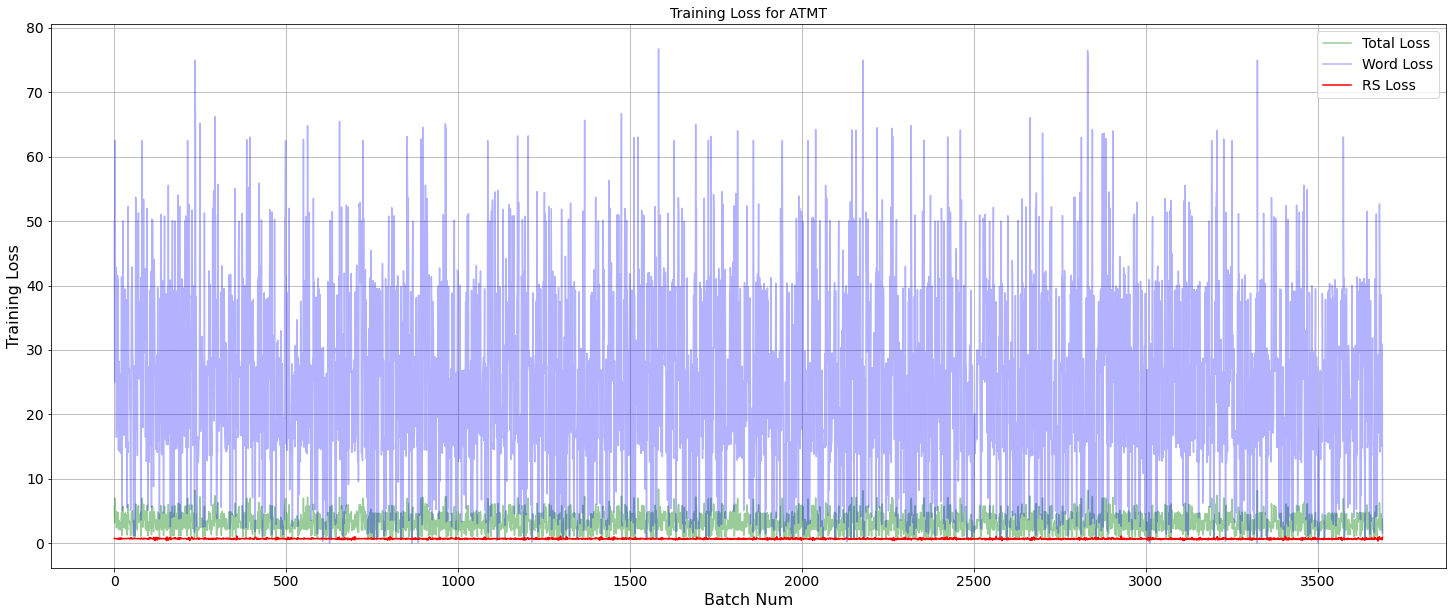

In [76]:
plot_epoch_loss_multi(losees_train_multi_att[(0.001, 0.1)])

In [59]:
losees_train_multi_att[(0.001, 0.8)]['rs_loss']

[0.7145814895629883,
 0.7410853505134583,
 0.6951789855957031,
 0.6950016021728516,
 0.6723767518997192,
 0.7462757229804993,
 0.7559142112731934,
 0.7009477615356445,
 0.7015202045440674,
 0.7577527761459351,
 0.6995474100112915,
 0.6778246164321899,
 0.7008443474769592,
 0.6946040987968445,
 0.6582146883010864,
 0.7267179489135742,
 0.7479531168937683,
 0.6285680532455444,
 0.704503059387207,
 0.6219009757041931,
 0.6614135503768921,
 0.6591708064079285,
 0.7283341884613037,
 0.5267069339752197,
 0.583290159702301,
 0.7510339617729187,
 0.8587870597839355,
 0.5799307823181152,
 0.910784125328064,
 0.7340894937515259,
 0.7841148376464844,
 0.7541832327842712,
 0.6649797558784485,
 0.6789827346801758,
 0.6907541751861572,
 0.6708680391311646,
 0.6894867420196533,
 0.7334756851196289,
 0.6940044164657593,
 0.7434961199760437,
 0.7757105827331543,
 0.7053206562995911,
 0.7058004140853882,
 0.6871036887168884,
 0.6902021169662476,
 0.6875417828559875,
 0.6963328123092651,
 0.6833150386810